# K-means
##### Sean Wade

In [301]:
from __future__ import division
import numpy as np
from scipy.spatial import distance
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from collections import Counter

from mltools.dataManager import DataManager

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://seanwade.com/jupyter.css').read())

In [411]:
class KMeans:
    """ My implementation of the K-means algorithms."""
    
    def __init__(self, variable_types):
        self.variable_types = variable_types
        
    def _distance(self, a, b):
        total = 0
        for i in range(len(a)):
            if self.variable_types[i] == True:
                if a[i] != b[i]:
                    total += 1
            else:
                total += np.sqrt((a[i] - b[i])**2)
        return total
    
    def _mean(self, data):
        mean = [0] * data.shape[1]
        for i in range(data.shape[1]):
            if self.variable_types[i] == True:
                mean[i] = Counter(data[:,i]).most_common(1)[0][0]
            else:
                mean[i] = np.mean(data[:,i])
        return np.array(mean)
    
    def fit(self, x_train, k=3):
        """ 
        Args:
          x_train : (np.ndarray) An NxD array array of points to cluster
          k : (int) The number of clusters
        """
        # Init Center Guess
        n, d = x_train.shape
        k_means = x_train[:k,:]
        
        diff = [np.inf]
        while any(x > 10e-5 for x in diff):
            prev_center = k_means.copy()
            # Calc Distance from all centers
            dist_matrix = np.zeros((n, k))
            for i in range(n):
                for j in range(k):
                     dist_matrix[i][j] = self._distance(x_train[i], k_means[j])
            # Group with the closest center
            group = []
            for i in range(n):
                group.append(np.argmin(dist_matrix[i,:]))
            group = np.array(group)
            
            # Recompute centers from group
            diff = []
            for i in range(k):
                k_means[i,:] = self._mean(x_train[np.where(group==i)])
                diff.append(self._distance(k_means[i], prev_center[i]))
            
        self.k_means = k_means
        self.k = k  
        self.number_to_group = dict(Counter(group))
        
        # calc SSE
        self.sse_list = []
        for i in range(k):
            sse = 0
            group_data = x_train[np.where(group==i)]
            for j in range(group_data.shape[0]):
                sse += self._distance(k_means[i], group_data[j,:])**2
            self.sse_list.append(sse)
            
        self.full_sse = np.sum(self.sse_list)
        
                
                

    def predict(self, x_test):
        """
        Args:
          x_test : (np.ndarray) Points to classify
          
        Returns
          class : (np.ndarray) Which cluster points belong to:
        """
        n, d = x_test.shape
        dist_matrix = np.zeros((n, self.k))
        for i in range(n):
            for j in range(self.k):
                 dist_matrix[i][j] = self._distance(x_test[i], self.k_means[j])
        # Group with the closest center
        group = []
        for i in range(n):
            group.append(np.argmin(dist_matrix[i,:]))
        return np.array(group)
        

singe vs complete

- single is the min distance between clusters
- complete is the max distance

## Output
- number of clusters
- centroid values
- number of instances to each cluster
- the SSE of each cluster
- SSE of full clustering

In [463]:
data = DataManager('datasets/iris.arff')
data.shuffle()

In [464]:
x_train, x_test, y_train, y_test = data.test_train_split()

In [465]:
model = KMeans(data.is_nominal_variable()[:-1])
model.fit(x_train)
y_hat = model.predict(x_test)

In [466]:
print accuracy_score(y_test, y_hat)

0.4


## Create Data

For demonstration we will create a synthetic dataset that is 300 points drawn from 3 different distributions.  The goal of kmeans is to find the center of each.

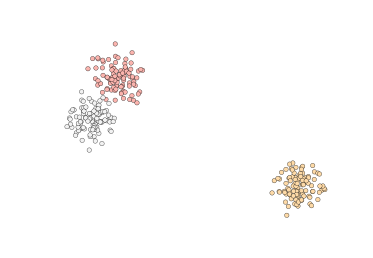

In [484]:
data, group = make_blobs(300)
plt.scatter(data[:,0], data[:,1], c=group, cmap=plt.cm.Pastel1)
plt.axis('off')
plt.show()

## Plot Results

In [485]:
model = KMeans([False, False])
model.fit(data, 3)

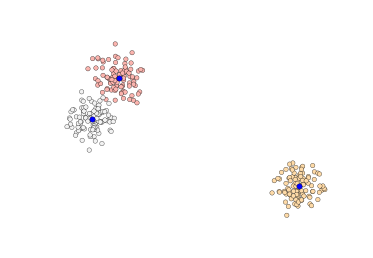

In [487]:
plt.scatter(data[:,0], data[:,1], c=group, cmap=plt.cm.Pastel1)
plt.scatter(model.k_means[:,0], model.k_means[:,1], c='b', s=30)
plt.axis('off')
plt.show()

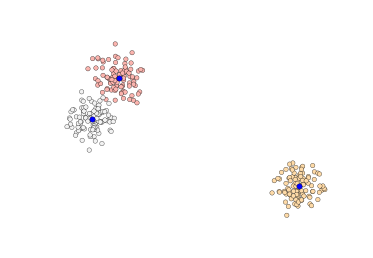

In [488]:
plt.scatter(data[:,0], data[:,1], c=group, cmap=plt.cm.Pastel1)
plt.scatter(model.k_means[:,0], model.k_means[:,1], c='b', s=30)
plt.axis('off')
plt.show()

### Plot the Decision Boundary

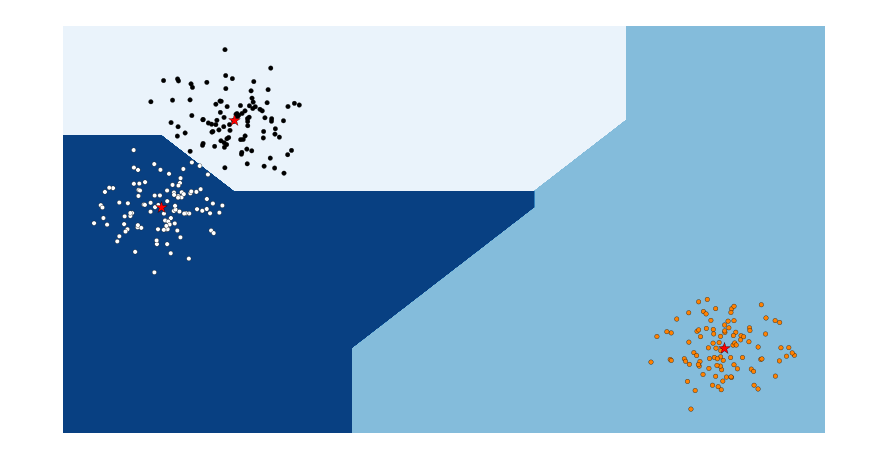

In [489]:
plt.figure(figsize=(15,8))
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
labels = model.predict(data)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues)

# Plot also the training points
plt.scatter(data[:,0], data[:,1], c=labels, cmap=plt.cm.afmhot)
plt.scatter(model.k_means[:,0], model.k_means[:,1], marker='*', c='r', s=150)
plt.axis('off')
plt.show()